<a href="https://colab.research.google.com/github/diptivs/machine_learning/blob/master/NELA_Reliable_Source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SJSU ML 2019 : CMPE 257

Professor: Dr. Arsanjani

Student ID: 013778570

Name: Dipti Shiralkar

#1. Configuration of the System : Iterative, Notebook, code structure, data, where will it reside, folders, cloud buckets etc.

**Datasets used:**
* We used NELA datasets available here: https://dataverse.harvard.edu/dataverse/nela
* Used 2018 dataset for rest of the features
* Used 2017 dataset to prepare a model for "Posts/Social Activities". *[ As Scraper code is changed. 2017 data file has full HTML with all tags which made social media (Facebook) data was available. But 2018 data files just have the articles]*

**Data amalgamation and filteration**
* Dataset was amalgamated with Labels.csv
* Filtered to reduce size to ~20k

To know the details please follow the colab here: https://colab.research.google.com/drive/1AUrn-rXd5EZlQKV6KMcT6DOeaL54xPG1

**Shared drive details**
* All the related data is shared on drive here: https://drive.google.com/open?id=1a4p_438ouSiD8O_sbFw_S3-WFoO4MtRi
  * aggregated_labels : shows the calculation for aggregated label
  * aggregated_labels.csv : Dataset having the aggrehated label for each source used for amalgmation
  * nela_aggregate_labels.csv : Amalgamated dataset; Articles DB + Labels
  * nela_score_values_reduced_ds.csv : Filtered dataset of size ~20k with even destribution of labels and sources
  * nela_score_values_reduced_ds_with_frq_cnt_1.csv to nela_score_values_reduced_ds_with_frq_cnt_4.csv: Dataset prepared by calculating Frequency of each article using cosine similarity. As train dataset is huge in size (700k), it was a time + processing exhaustive process to find cosine similarity. Hence divided into parallel processes, generated seperate colabs and then merged it.

**Factor description:**
Whenever one reads news after noting “who said”, he tends to look for “who published” the news. This is considered as a source of news. It’s been observed that is a source has published fake news before, there’s a good chance they’ll do it again. Hence the reliability factor of source of news is a good indicator towards fakeness of news. This indicates how thoroughly source validates the news before actually publishing it.



#2. Data Collection : initial Data Set
As discussed, the amalgamated and filtered dataset is used as base dataset.

nela_score_values_reduced_ds.csv: https://drive.google.com/open?id=1-MdGo8vMMLWMZBcb_K0dKz56FzNEra7W

###Feature set description

* Reliable Source: The features used for this factor are listed below:

| Source	| Name | Aggregated |
| --- | ---| ---|

* Source: Name of source
* Name: Title of article
* Aggregated: Aggregated label for the given source


#3. Narration

In this colab a ML model is developed to predict the fakeness of news considering the factor "Reliable Source".

**Description**: Whenever one reads news after noting “who said”, he tends to look for “who published” the news. This is considered as a source of news. It’s been observed that is a source has published fake news before, there’s a good chance they’ll do it again. Hence the reliability factor of source of news is a good indicator towards fakeness of news. This indicates how thoroughly source validates the news before actually publishing it.

###Imports

In [0]:
import sqlite3
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('wordnet')
import nltk
nltk.download('punkt')

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import gensim
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##Load dataset

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#https://drive.google.com/open?id=1-MdGo8vMMLWMZBcb_K0dKz56FzNEra7W
file_id = '1-MdGo8vMMLWMZBcb_K0dKz56FzNEra7W'
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('nela_score_values_reduced_ds.csv') 
data_in = pd.read_csv('nela_score_values_reduced_ds.csv')
data_in.head()

,Unnamed: 0,Unnamed: 0.1,date,source,name,content,aggregated
0,0,0,2018-02-01,DC Gazette,SHOCKER Key GOP House Member TREY GOWDY Not Se...,"It wasnt exactly widely known, but South Carol...",1.0
1,1,1,2018-02-01,DC Gazette,Saudi Arabia Seizes BILLIONS In Anti-Corruptio...,Amazing what happens when a government activel...,1.0
2,2,2,2018-02-01,Freedom Outpost,10 Amazing Facts About Americas Economic Recov...,If the U.S. economy continues to surge under P...,1.0
3,3,3,2018-02-01,Freedom Outpost,Democrats Have Absolutely No Class They Put It...,After observing the despicable behavior of the...,1.0
4,4,4,2018-02-01,Freedom Outpost,ReleaseTheMemo Even Democrats Are Admitting Th...,Never before has there been so much talk about...,1.0


#5. Data Prep: Curation

1. Feature Selection and Extraction : what are the main features to use in this data set?

This was done as part of Section 4 using SelectKBest and .corr

2. Data Verification: Do we have enough data?

Data was filtered to reduce the data size as discussed in Section 1.

3. Possibility of Amalgamation1: Add Dataset 2

Amalgamated Article DB with Labels dataset to get aggregated label for each source.

4. Data Cleansing

NLP lifecycle is followed:
  * Drop rows with NULL values
  * Convert strings to lowercase
  * Remove stop words
  * Lemmatize
  * Stemming
  * remove_punctuation




###Data cleaning

In [0]:
#method to remove punctuations from textual data
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [0]:
sw = stopwords.words('english')
stemmer = SnowballStemmer("english")

#Remove stop words
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

#Lemmetize and pos tagging
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

#Stemming
def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [0]:
def text_preprocess(df):
    df = df[pd.notnull(df['name'])]
    df = df[pd.notnull(df['source'])]
    #convert to lower case
    df['source'] = df['source'].str.lower()
    #remove stop words
    df['source'] = df['source'].apply(remove_stopwords)
    #Lemmetize
    df['source'] = df['source'].apply(lemmatize_stemming)
    #stemming
    df['source'] = df['source'].apply(stemming)
    #remove punctuation
    df['source'] = df['source'].apply(remove_punctuation)
    #remove less than 3 letter words
    df['source']  = df.source.apply(lambda i: ' '.join(filter(lambda j: len(j) > 3, i.split())))


    #convert to lower case
    df['name'] = df['name'].str.lower()
    #remove stop words
    df['name'] = df['name'].apply(remove_stopwords)
    #Lemmetize
    df['name'] = df['name'].apply(lemmatize_stemming)
    #stemming
    df['name'] = df['name'].apply(stemming)
    #remove punctuation
    df['name'] = df['name'].apply(remove_punctuation)
    
    return df[['source', 'name', 'aggregated']]

In [0]:
#pre-processing train dataset
df_processor = text_preprocess(data_in)
df_processor.head(5)

,source,name,aggregated
0,gazett,shocker key gop hous member trey gowdi seek re...,1.0
1,gazett,saudi arabia seiz billion anticorrupt settl,1.0
2,freedom outpost,10 amaz fact america econom recoveri trump sta...,1.0
3,freedom outpost,democrat absolut class put display sotu,1.0
4,freedom outpost,releasethememo even democrat admit could get m...,1.0


In [0]:
df_processor.dtypes

source         object
name           object
aggregated    float64
dtype: object

In [0]:
df_processor.dropna(how='any',axis=0)

,source,name,aggregated
0,gazett,shocker key gop hous member trey gowdi seek re...,1.0
1,gazett,saudi arabia seiz billion anticorrupt settl,1.0
2,freedom outpost,10 amaz fact america econom recoveri trump sta...,1.0
3,freedom outpost,democrat absolut class put display sotu,1.0
4,freedom outpost,releasethememo even democrat admit could get m...,1.0
...,...,...,...
20036,washington,capit journal trump stand saudi arabia overloo...,5.0
20037,washington,capit journal trump border call us urg alli sh...,5.0
20038,washington,capit journal critic lameduck session commenc ...,5.0
20039,washington,capit journal trump talk china gm wsj mississi...,5.0


In [0]:
df_processor.shape

(20040, 3)

In [0]:
df_processor.head()

,source,name,aggregated
0,gazett,shocker key gop hous member trey gowdi seek re...,1.0
1,gazett,saudi arabia seiz billion anticorrupt settl,1.0
2,freedom outpost,10 amaz fact america econom recoveri trump sta...,1.0
3,freedom outpost,democrat absolut class put display sotu,1.0
4,freedom outpost,releasethememo even democrat admit could get m...,1.0


In [0]:
import numpy as np
df_processor['aggregated'] = df_processor['aggregated'].apply(np.int64)

##Split train and test

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_processor[['source', 'name']], df_processor['aggregated'], test_size=0.25, random_state=42)


In [0]:
tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                                   analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5),
                                   use_idf=1, smooth_idf=1, sublinear_tf=1, lowercase=False)

In [0]:
X_train_source = tfidf.fit_transform(X_train['source'])
X_test_source  = tfidf.transform(X_test['source'])

In [0]:
X_train_name = tfidf.fit_transform(X_train['name'])
X_test_name  = tfidf.transform(X_test['name'])

In [0]:
X_train_transformed = sparse.hstack([X_train_source, X_train_name]).tocsr()
X_test_transformed  = sparse.hstack([X_test_source, X_test_name]).tocsr()

#4. Exploratory Data Analysis and Visualization

##4.1 feature analysis and engineering (for ML, for DL it's feature extraction)


###Information of dataset

The source and name are text and need to be converted to vector. Aggregated value of label is an integer.

In [0]:
#information of dataset
df_processor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20040 entries, 0 to 20040
Data columns (total 3 columns):
source        20040 non-null object
name          20040 non-null object
aggregated    20040 non-null int64
dtypes: int64(1), object(2)
memory usage: 626.2+ KB


##4.2 Analyze data 

###Check for null values
Dataset looks clean as no null values

In [0]:
#checking null values
df_processor.isnull().sum()

source        0
name          0
aggregated    0
dtype: int64

##4.3 Visualization

In [0]:
def fake_news_distribution(df):
    #Training data set with text, domain ranking and type.
    X = df[['source', 'aggregated']]

    plt.title('Category Vs Count')
    X.groupby(['aggregated']).size().plot(kind='barh', color='blue')
    plt.xlabel('count')
    plt.show()

Fake News Aggregated Label Destribution


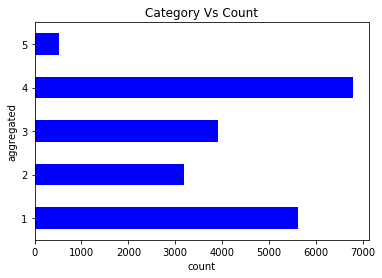

In [0]:
print('Fake News Aggregated Label Destribution')
fake_news_distribution(df_processor)

###word2vec an tSNE

In [0]:
# Grab all the titles 
article_titles = df_processor['name']
# Create a list of strings, one for each title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['shocker',
 'key',
 'gop',
 'hous',
 'member',
 'trey',
 'gowdi',
 'seek',
 'reelect',
 'saudi']

In [0]:
! wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2019-12-17 19:57:51--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.185.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.185.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  41.2MB/s    in 38s     

2019-12-17 19:58:30 (41.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)


# Check dimension of word vectors
model.vector_size

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


300

In [0]:
economy_vec = model['economy']
economy_vec[:20] # First 20 components

array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

In [0]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [0]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

0 docs removed
0 docs removed


In [0]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

In [0]:
from sklearn.manifold import TSNE
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])

In [0]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=a132760bd795a4106207d26933dc731c3c51b2bc23f1c61602011b108d3682d7
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


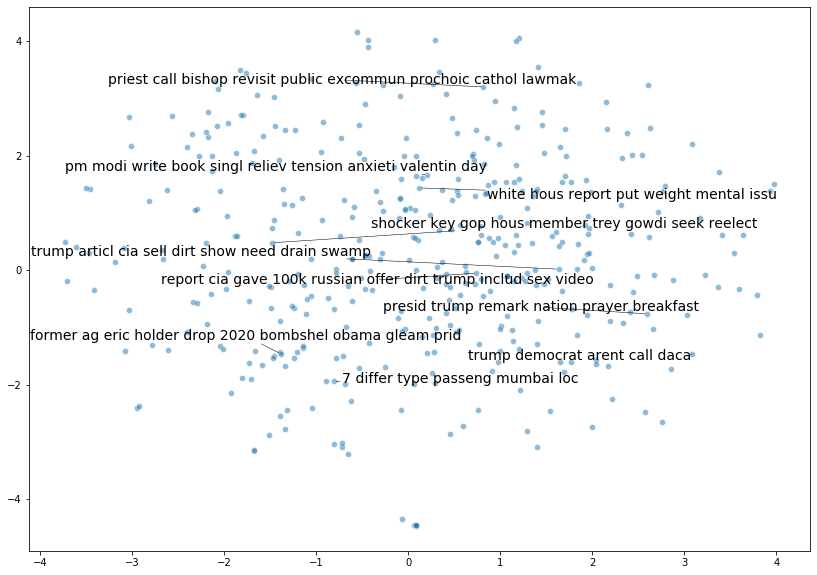

In [0]:
import seaborn as sns
from adjustText import adjust_text

fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

###Word Cloud 

In [0]:
#Word Cloud to Visualize important text
# lower max_font_size, change the maximum number of word and lighten the background

def word_cloud_visualization(df):
    text = " ".join(ht for ht in df['name'])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Word Cloud Visualization


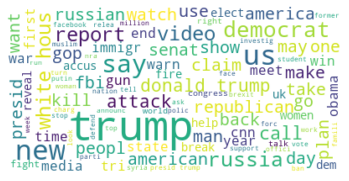

In [0]:

print('Word Cloud Visualization')
word_cloud_visualization(df_processor)


#6. Unsupervised Exploration : Find relevant Clusters in Your Data
1. How many clusters? Explore different k’s…

Plotted Elbow which shows Best K value is inbetween 3 and 4. SO plotted GMM with 3 and Kmean using 4
2. Select Clustering algorithms, run several and compare in a table

**silhouette_score of**

* GMM is : -0.0055538104
* Kmean is: -0.0055538104

3. What does each cluster mean? How do they contribute to your Data Narrative (Story)
There are the clusters for the article titles. Clusters looks very cluttered and silhouette_score is also not good. Which kind of indicates that the articles are from different sources, different topics and can not be really grouped into clusters.

###Elbow

Text(0.5, 1.0, 'Elbow curve')

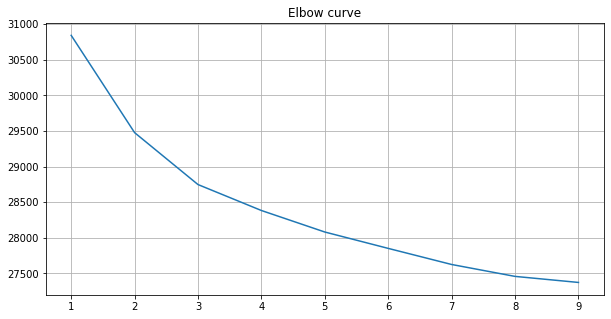

In [0]:
from sklearn.cluster import KMeans

#X --> document term matrix from section  "word2vec an tSNE" above

distorsions = []
for k in range(1, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

###GMM

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


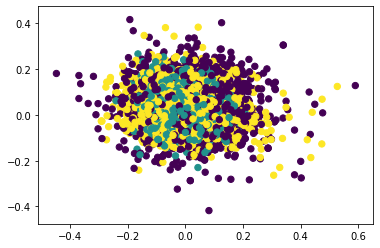

In [0]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [0]:
from sklearn.metrics import silhouette_score

silhouette_score(X, labels)

-0.0055538104

###Kmean

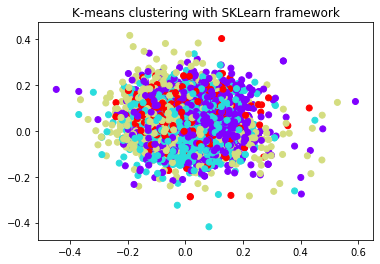

In [0]:
kmeans = KMeans(n_clusters = 4).fit(X)
centroids = kmeans.cluster_centers_
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.title("K-means clustering with SKLearn framework")
plt.show()

In [0]:
silhouette_score(X, labels)

-0.0055538104

#7. Supervised Training Preparation: Data Curation : label your data set

1. Classify Your Data Sets : Run different classification algorithms
Check further for classification algorithms:
* Multinomial Bayes
* Descision Tree
* SVM
* KNN

2. Measure Classification Success

| Algorithm	| Accuracy |
| --- | ---|
| Multinomial Bayes |	96.07% |
| Descision Tree | 43.47% |
| SVM | 33.95%|
| KNN | 97.14%|

3. What regression objectives should we have? Complete your , add to your Data Story 
4. Run Regressions using various algorithms
Check further for Linear and logistic regression on dataset.
5. Measure Success of Regressions and
Confusion matrix is plotted with algorithms below and sicusses in next section of results.
6. Compare Regressions in a table 

| Algorithm |	Accuracy |
| --- | --- |
| Logistic Regression |	96.94% |
| Linear Regression	| 89.78% |

###Data is already divided into train and test in section 5, using 25% of data as test and 75% as train.

In [0]:
accuracies = {}

##Multinomial Bayes
* Accuracy_score:0.9600798403193613
* Confusion matrix: It is 5X5matrix as we have 5 Labels. The diagonal values shows that for most of the Labels values were predicted correct. Top right corner is mostly 0 which indicates very few "False positives"

In [0]:
nb = MultinomialNB(alpha=1)

In [0]:
%time nb.fit(X_train_transformed, y_train)

CPU times: user 11.3 ms, sys: 1.72 ms, total: 13 ms
Wall time: 17.3 ms


MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [0]:
y_mnb_pred = nb.predict(X_test_transformed)
print(y_mnb_pred)

[1 2 4 ... 1 1 3]


In [0]:
from sklearn.metrics import accuracy_score
# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, y_mnb_pred)
accuracies['MultinomialNB'] = accuracy_test
print('accuracy_score on test dataset MultinomialNB : ', accuracy_test)

accuracy_score on test dataset MultinomialNB :  0.9600798403193613


In [0]:
print(classification_report(y_test,y_mnb_pred))

              precision    recall  f1-score   support

           1       0.96      1.00      0.98      1412
           2       0.99      0.89      0.94       809
           3       0.96      0.98      0.97       943
           4       0.94      0.98      0.96      1701
           5       1.00      0.63      0.77       145

    accuracy                           0.96      5010
   macro avg       0.97      0.90      0.92      5010
weighted avg       0.96      0.96      0.96      5010



In [0]:
print(confusion_matrix(y_test,y_mnb_pred))

[[1412    0    0    0    0]
 [  27  723   23   36    0]
 [   2    1  922   18    0]
 [  21    7   11 1662    0]
 [   6    1    0   47   91]]


##Descision Tree
* Accuracy Score: 0.4347305389221557
* COnfusion matrix: shows lot of False positives

In [0]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
%matplotlib inline

clf = DecisionTreeClassifier(criterion='entropy', max_depth =2, min_samples_split=2, min_samples_leaf=6)
clf.fit(X_train_transformed, y_train)

prediction = clf.predict(X_test_transformed)

In [0]:
# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, prediction)
accuracies['Descision Tree'] = accuracy_test
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.4347305389221557


In [0]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           1       0.86      0.22      0.35      1412
           2       0.00      0.00      0.00       809
           3       0.56      0.18      0.27       943
           4       0.39      1.00      0.56      1701
           5       0.00      0.00      0.00       145

    accuracy                           0.43      5010
   macro avg       0.36      0.28      0.24      5010
weighted avg       0.48      0.43      0.34      5010



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print(confusion_matrix(y_test,prediction))

[[ 307    0    0 1105    0]
 [  35    0  131  643    0]
 [  17    0  170  756    0]
 [   0    0    0 1701    0]
 [   0    0    0  145    0]]


##SVM

In [0]:

from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train_transformed,y_train) 
prediction = clf.predict(X_test_transformed)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, prediction)
accuracies['SVM'] = accuracy_test
print('accuracy_score on test dataset : ', accuracy_test)

print(classification_report(y_test,prediction))


accuracy_score on test dataset :  0.3395209580838323
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1412
           2       0.00      0.00      0.00       809
           3       0.00      0.00      0.00       943
           4       0.34      1.00      0.51      1701
           5       0.00      0.00      0.00       145

    accuracy                           0.34      5010
   macro avg       0.07      0.20      0.10      5010
weighted avg       0.12      0.34      0.17      5010



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print(confusion_matrix(y_test,prediction))

[[   0    0    0 1412    0]
 [   0    0    0  809    0]
 [   0    0    0  943    0]
 [   0    0    0 1701    0]
 [   0    0    0  145    0]]


##KNN

In [0]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train_transformed,y_train)
prediction = knn.predict(X_test_transformed)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, prediction)
accuracies['KNN'] = accuracy_test
print('accuracy_score on test dataset : ', accuracy_test)

print(classification_report(y_test,prediction))


accuracy_score on test dataset :  0.9714570858283433
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1412
           2       1.00      0.91      0.95       809
           3       1.00      0.97      0.98       943
           4       0.92      1.00      0.96      1701
           5       0.99      0.75      0.85       145

    accuracy                           0.97      5010
   macro avg       0.98      0.93      0.95      5010
weighted avg       0.97      0.97      0.97      5010



In [0]:
print(confusion_matrix(y_test,prediction))

[[1412    0    0    0    0]
 [   0  735    0   74    0]
 [   0    1  911   31    0]
 [   0    0    0 1700    1]
 [   0    1    1   34  109]]


##Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression()
lg.fit(X_train_transformed,y_train)
prediction=lg.predict(X_test_transformed)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, prediction)
accuracies['Logistic Regression'] = accuracy_test
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.9694610778443113


In [0]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1412
           2       1.00      0.90      0.95       809
           3       1.00      0.96      0.98       943
           4       0.92      1.00      0.96      1701
           5       1.00      0.72      0.84       145

    accuracy                           0.97      5010
   macro avg       0.98      0.92      0.95      5010
weighted avg       0.97      0.97      0.97      5010



In [0]:
print(confusion_matrix(y_test,prediction))

[[1412    0    0    0    0]
 [   0  732    0   77    0]
 [   0    0  907   36    0]
 [   0    0    0 1701    0]
 [   0    0    0   40  105]]


##Linear Regression

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00         0
         1.0       0.97      0.94      0.96      1412
         2.0       0.89      0.83      0.86       809
         3.0       0.84      0.91      0.87       943
         4.0       0.93      0.90      0.92      1701
         5.0       0.63      0.66      0.64       145
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0

    accuracy                           0.90      5010
   macro avg       0.47      0.47      0.47      5010
weighted avg       0.91      0.90      0.90      5010

[[   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   1   36 1330   43    2    0    0    0    0]
 [   0    0   40  674   45   49    1    0    0]
 [   0    0    0   42  860   41    0    0    0]
 [   0    0    0    0  106 1538   56    0    1]
 [   0 

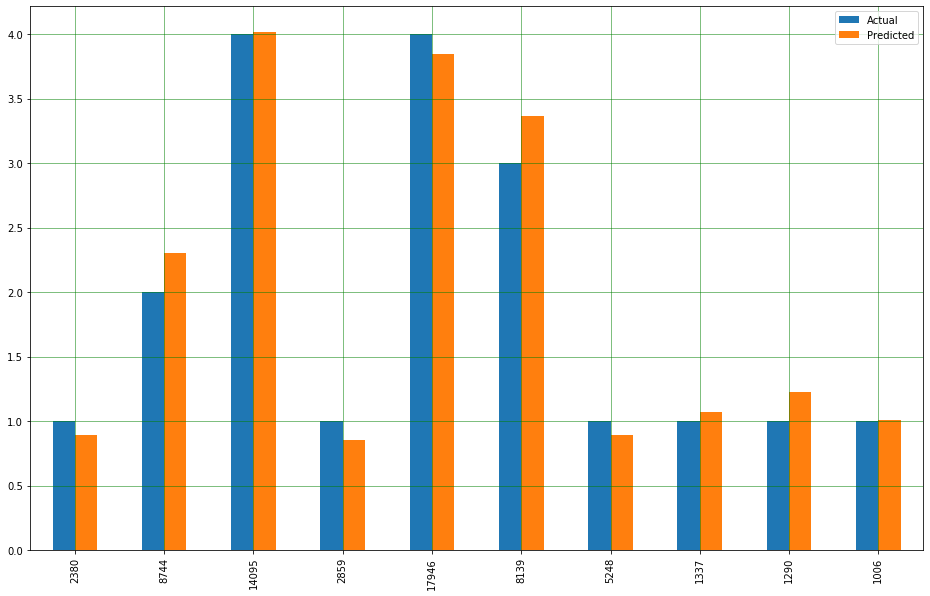

In [0]:
regressor = LinearRegression()  
regressor.fit(X_train_transformed, y_train)

prediction = regressor.predict(X_test_transformed)

print(classification_report(y_test,prediction.round()))

print(confusion_matrix(y_test,prediction.round()))

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, prediction.round())
accuracies['Linear Regression'] = accuracy_test
print('accuracy_score on test dataset : ', accuracy_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': prediction})
df1 = df.head(10)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#8. Metrics and Evaluation

The best performnace is by **"Multinomial Bayes"** and "**KNN**"

Discussion around results of Multinomial Bayes:
* Accuracy: 96.07%
* Confusion matrix: It is 5X5matrix as we have 5 Labels. The diagonal values shows that for most of the Labels values were predicted correct. Top right corner is mostly 0 which indicates very few "False positives"

|Label1 | Label2 | Lable3 | Lalel4 | Label5|
| --- | ---| ---| ---| ---|
|1412 |   0 |   0 |   0  |  0|
|27 |  723 |   23 |  36 |   0|
| 2 |   1 | 922  | 18  |  0 |
| 21  |  7  | 11  | 1662  |  0|
|6   |  1  |  0 |  47 |  91|

In [0]:
from IPython.display import display, HTML
table = "<table><thead><tr><th>Algorithm</th><th>Accuracy</th></tr></thead><tbody>"
#print("--- | ---")
for algo, accuracy in accuracies.items():
  table+="<tr><td>{}</td><td>{}%</td></tr>".format(algo, accuracy*100)
table+="</tbody></table>"
display(HTML(table))

Algorithm,Accuracy
MultinomialNB,96.00798403193613%
Descision Tree,43.47305389221557%
SVM,33.952095808383234%
KNN,97.14570858283433%
Logistic Regression,96.94610778443113%
Linear Regression,89.78043912175649%
